<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
HOST = "localhost"
PORT = 8080
PROTOCOL = "http"

url = PROTOCOL + "://" + HOST + ":" + str(PORT)
url

'http://localhost:8080'

In [2]:
import pandas as pd

cpds = pd.read_csv("cpds_MetaP.csv")
cpds

,MetaQSAR,SMILES,# compound,InChI
0,yes,CC1=C(C2=C(CCC(O2)(C)COC3=CC=C(C=C3)CC4C(=O)NC...,Troglitazone,InChI=1S/C24H27NO5S/c1-13-14(2)21-18(15(3)20(1...
1,yes,CCC1=CN=C(C=C1)CCOC2=CC=C(C=C2)CC3C(=O)NC(=O)S3,Pioglitazone,InChI=1S/C19H20N2O3S/c1-2-13-3-6-15(20-12-13)9...
2,yes,CN(CCOC1=CC=C(C=C1)CC2C(=O)NC(=O)S2)C3=CC=CC=N3,Rosiglitazone,InChI=1S/C18H19N3O3S/c1-21(16-4-2-3-9-19-16)10...
3,yes,C1=CC=C(C(=C1)CC(=O)O)NC2=C(C=CC=C2Cl)Cl,Diclofenac,InChI=1S/C14H11Cl2NO2/c15-10-5-3-6-11(16)14(10...
4,no,C1=CC(=C(C(=C1)C(=O)C2=CC=C(C=C2)Br)N)CC(=O)O,Bromfenac,InChI=1S/C15H12BrNO3/c16-11-6-4-9(5-7-11)15(20...
5,yes,CC1=CC(=C(C=C1)NC2=C(C=CC=C2Cl)F)CC(=O)O,Lumiracoxib,InChI=1S/C15H13ClFNO2/c1-9-5-6-13(10(7-9)8-14(...
6,no,CC1=C(C(=NO1)C2=C(C=CC=C2Cl)F)C(=O)NC3C4N(C3=O...,Flucloxacillin,InChI=1S/C19H17ClFN3O5S/c1-7-10(12(23-29-7)11-...
7,yes,C1C2C(C2N)CN1C3=C(C=C4C(=O)C(=CN(C4=N3)C5=C(C=...,Trovafloxacin,InChI=1S/C20H15F3N4O3/c21-8-1-2-15(13(22)3-8)2...
8,yes,CCC1=NN(C(=O)N1CCOC2=CC=CC=C2)CCCN3CCN(CC3)C4=...,Nefazodone,InChI=1S/C25H32ClN5O2/c1-2-24-27-31(25(32)30(2...
9,yes,CC1=CC=C(C=C1)C(=O)C2=CC(=C(C(=C2)O)O)[N+](=O)...,Tolcapone,InChI=1S/C14H11NO5/c1-8-2-4-9(5-3-8)13(17)10-6...


In [5]:
import requests
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import rdDepictor

def process_molecule(mol_pred):
    atom_predictions = pd.DataFrame(mol_pred['atomPredictions'])
    rdmol = Chem.MolFromMolBlock(mol_pred['MDLBlock'])
    rdDepictor.Compute2DCoords(rdmol)
    
    atom_predictions["# compound"] = mol_pred['molName']
    atom_predictions["MDLBlock"] = mol_pred['MDLBlock']
    return mol_pred['molName'], rdmol, atom_predictions

parameters = {
    'modelName' : 'P2'
    , 'bondDepth' : "DEPTH_2"
    , 'useFAMEScore' : False # turn this off for faster calculation
    , 'smiles' : cpds["SMILES"].tolist()
    , 'names' : cpds["# compound"].tolist()
    , 'decisionThreshold' : "model"
}

resp = requests.get(
        url + '/prediction'
        , params=parameters
        , headers={"accept" : "application/json"}
    )
results = pd.DataFrame()
mols = dict()
errors = []
if resp.ok:
    json_data = resp.json()
    for prediction in json_data['predictions']:
        parsed_results = process_molecule(prediction)
        mols[parsed_results[0]] = parsed_results[1]
        results = results.append(parsed_results[2])
else:
    print("Prediction failed...")
    errors.append(resp)

results.to_csv("results_{0}_{1}.csv".format(parameters["modelName"], parameters["bondDepth"]), index=False)
print("Molecules predicted:", len(mols))
results.head()

Molecules predicted: 13


,atomID,element,probability,decision,FAMEscore,# compound,MDLBlock
0,1,C,0.0,False,None,Valproic acid,Valproic acid\n CDK 0821191350\n\n 26 25 ...
1,2,C,0.0,False,None,Valproic acid,Valproic acid\n CDK 0821191350\n\n 26 25 ...
2,3,C,0.0,False,None,Valproic acid,Valproic acid\n CDK 0821191350\n\n 26 25 ...
3,4,C,0.0,False,None,Valproic acid,Valproic acid\n CDK 0821191350\n\n 26 25 ...
4,5,C,0.0,False,None,Valproic acid,Valproic acid\n CDK 0821191350\n\n 26 25 ...


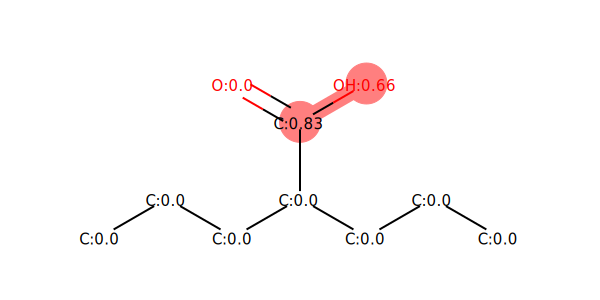

Valproic acid


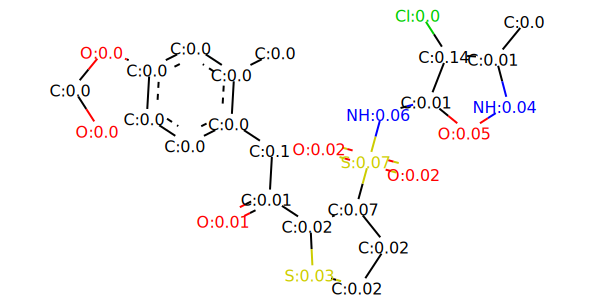

Sitaxentan


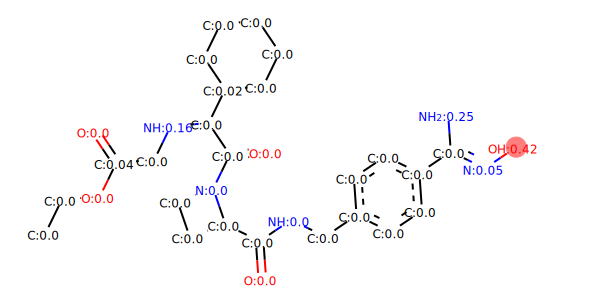

Ximelagatran


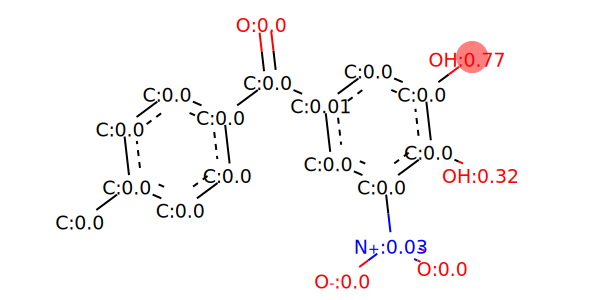

Tolcapone


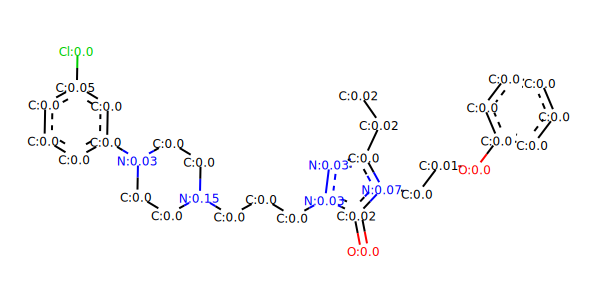

Nefazodone


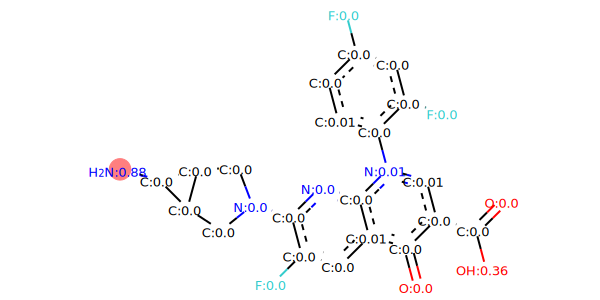

Trovafloxacin


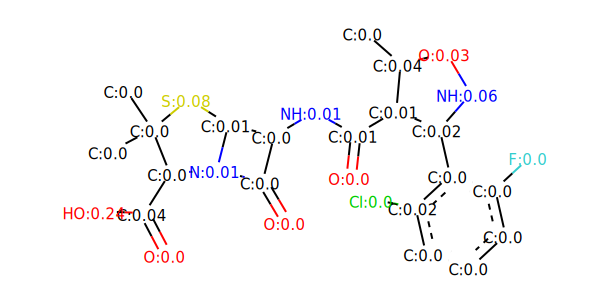

Flucloxacillin


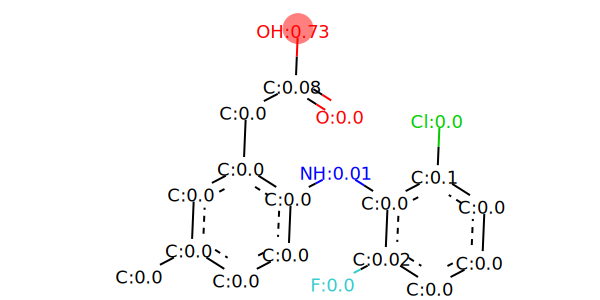

Lumiracoxib


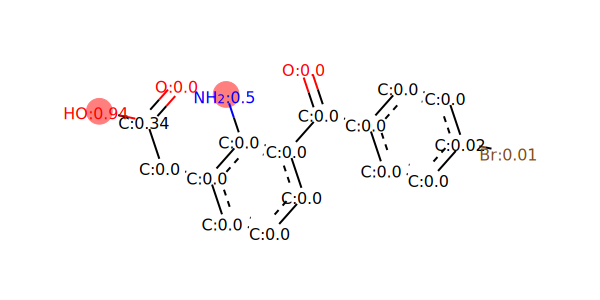

Bromfenac


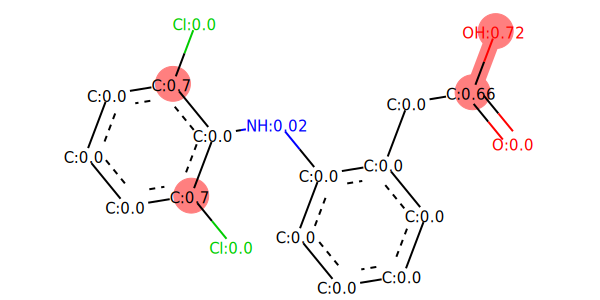

Diclofenac


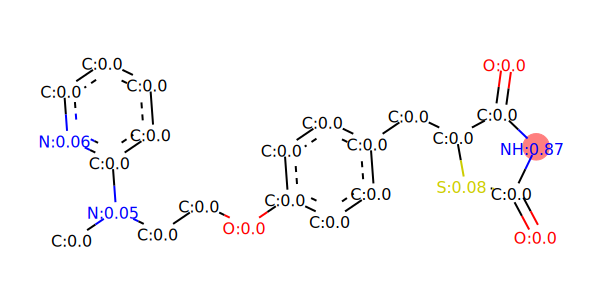

Rosiglitazone


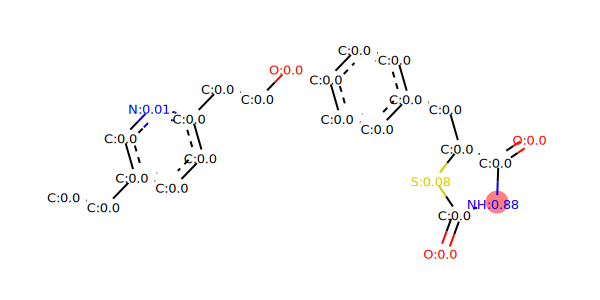

Pioglitazone


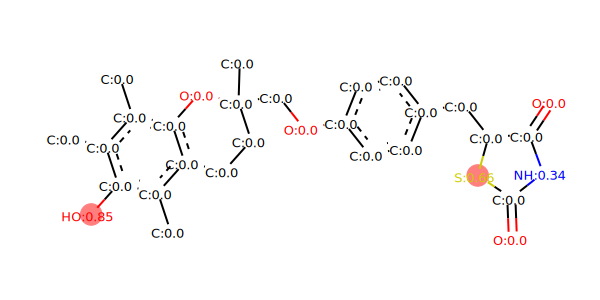

Troglitazone


In [6]:
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from rdkit.Chem.Draw import rdMolDraw2D

def mol_with_atom_index( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol

def show_soms(mol, som_data):
#     mol = mol_with_atom_index(mol)
    for idx, atom in enumerate(mol.GetAtoms()):
        atom.SetProp('molAtomMapNumber', str(round(som_data["probability"][idx], 2)))
    drawer = rdMolDraw2D.MolDraw2DSVG(600,300)
    drawer.DrawMolecule(mol, highlightAtoms=[i for i, x in enumerate(som_data["decision"]) if x])
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace('svg:','')
    return SVG(svg)

for mol in mols:
    display(show_soms(
        mols[mol]
        , results.loc[results["# compound"] == mol,:]
    ))
    print(mol)